# Ames Housing Dataset Modeling

This notebook contains model development for the Ames Housing dataset, including:
- Missing value imputation
- Data preprocessing
- Train/test splitting
- 10-fold cross validation with multiple models:
  - Ridge Regression
  - Lasso Regression
  - Random Forest
  - PyTorch Neural Network

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

## 1. Data Loading

In [3]:
# Load the dataset (adjust path as needed)
try:
    df = pd.read_csv('data/ames_housing_train.csv')
except FileNotFoundError:
    # Try alternative path
    try:
        df = pd.read_csv('train.csv')
    except FileNotFoundError:
        print("Please ensure the Ames Housing dataset (train.csv) is in the current directory or data/ folder")

# Display basic information
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# Check for missing values
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
print(f"Number of features with missing values: {len(missing_values)}")
missing_values

Number of features with missing values: 19


PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64

## 2. Missing Values Imputation
### 2.1. Remove variables with lots of missing values


In [5]:
df = df.drop(["PoolQC","MiscFeature","Alley","Fence","MasVnrType","FireplaceQu"],axis=1)

### 2.2. Impute missing values
- Split input data into numerical and categorical features
- Impute numerical with mean values
- Impute categorical feature with most_frequent values

In [6]:
# Identify numeric and categorical columns
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

# Remove target variable from features
if 'SalePrice' in numeric_features:
    numeric_features.remove('SalePrice')

# Create imputers for numeric and categorical data
numeric_imputer = SimpleImputer(strategy='mean')
categorical_imputer = SimpleImputer(strategy='most_frequent')

# Apply imputation
df[numeric_features] = numeric_imputer.fit_transform(df[numeric_features])
df[categorical_features] = categorical_imputer.fit_transform(df[categorical_features])

# Verify no missing values remain
print(f"Missing values after imputation: {df.isnull().sum().sum()}")

Missing values after imputation: 0


## 3. Data Preprocessing
- Split data into X, y
- Apply imputation and standardization

In [7]:
# Prepare the target variable
y = df['SalePrice']

# Log transform the target variable (common for house prices)
y = np.log1p(y)

# Prepare the feature matrix
X = df.drop('SalePrice', axis=1)

# Create a preprocessor for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

## 4. Train-Test Split

In [8]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (1168, 74)
Testing set shape: (292, 74)


## 5. Model Training with 10-fold Cross-Validation

### 5.1 Ridge Regression

In [9]:
# Create Ridge Regression pipeline
ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', Ridge(alpha=1.0))
])

# Set up 10-fold cross validation
kf = KFold(n_splits=10, shuffle=True, random_state=123)

# Perform cross-validation
ridge_cv_scores = cross_val_score(ridge_pipeline, X_train, y_train, cv=kf, 
                                scoring='neg_mean_squared_error')

# Convert negative MSE to RMSE
ridge_rmse_scores = np.sqrt(-ridge_cv_scores)

print("Ridge Regression 10-fold CV Results:")
print(f"Mean RMSE: {ridge_rmse_scores.mean():.4f}")
print(f"Std RMSE: {ridge_rmse_scores.std():.4f}")

# Train on the full training set
ridge_pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred_ridge = ridge_pipeline.predict(X_test)

# Calculate metrics on test set
ridge_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
ridge_test_r2 = r2_score(y_test, y_pred_ridge)

print(f"\nTest RMSE: {ridge_test_rmse:.4f}")
print(f"Test R²: {ridge_test_r2:.4f}")

Ridge Regression 10-fold CV Results:
Mean RMSE: 0.1488
Std RMSE: 0.0418

Test RMSE: 0.1137
Test R²: 0.9130


### 5.2 Lasso Regression

In [10]:
# Create Lasso Regression pipeline
lasso_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', Lasso(alpha=0.001))
])

# Perform cross-validation
lasso_cv_scores = cross_val_score(lasso_pipeline, X_train, y_train, cv=kf, 
                                 scoring='neg_mean_squared_error')

# Convert negative MSE to RMSE
lasso_rmse_scores = np.sqrt(-lasso_cv_scores)

print("Lasso Regression 10-fold CV Results:")
print(f"Mean RMSE: {lasso_rmse_scores.mean():.4f}")
print(f"Std RMSE: {lasso_rmse_scores.std():.4f}")

# Train on the full training set
lasso_pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred_lasso = lasso_pipeline.predict(X_test)

# Calculate metrics on test set
lasso_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
lasso_test_r2 = r2_score(y_test, y_pred_lasso)

print(f"\nTest RMSE: {lasso_test_rmse:.4f}")
print(f"Test R²: {lasso_test_r2:.4f}")

Lasso Regression 10-fold CV Results:
Mean RMSE: 0.1445
Std RMSE: 0.0471

Test RMSE: 0.1040
Test R²: 0.9272


### 5.3 Random Forest

In [17]:
# Create Random Forest pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=10, random_state=123))
])

# Perform cross-validation
rf_cv_scores = cross_val_score(rf_pipeline, X_train, y_train, cv=kf, 
                              scoring='neg_mean_squared_error')

# Convert negative MSE to RMSE
rf_rmse_scores = np.sqrt(-rf_cv_scores)

print("Random Forest 10-fold CV Results:")
print(f"Mean RMSE: {rf_rmse_scores.mean():.4f}")
print(f"Std RMSE: {rf_rmse_scores.std():.4f}")

# Train on the full training set
rf_pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_pipeline.predict(X_test)

# Calculate metrics on test set
rf_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_test_r2 = r2_score(y_test, y_pred_rf)

print(f"\nTest RMSE: {rf_test_rmse:.4f}")
print(f"Test R²: {rf_test_r2:.4f}")

Random Forest 10-fold CV Results:
Mean RMSE: 0.1541
Std RMSE: 0.0214

Test RMSE: 0.1402
Test R²: 0.8676


### 5.4 PyTorch Neural Network

In [18]:
# First, we need to preprocess the data for PyTorch
# Apply preprocessing to the full dataset
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)


In [20]:

# Define the Neural Network model
class HousingNN(nn.Module):
    def __init__(self, input_dim):
        super(HousingNN, self).__init__()
        self.layer1 = nn.Linear(input_dim, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 32)
        self.layer4 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.dropout(x)
        x = self.relu(self.layer2(x))
        x = self.dropout(x)
        x = self.relu(self.layer3(x))
        x = self.layer4(x)
        return x

In [21]:
# Function to train the neural network
def train_nn(X_train, y_train, input_dim, epochs=100, batch_size=32):
    # Convert to PyTorch tensors
    # Handle sparse matrix by converting to dense array first
    from scipy import sparse
    if sparse.issparse(X_train):
        X_train_tensor = torch.FloatTensor(X_train.toarray())
    else:
        X_train_tensor = torch.FloatTensor(X_train)
        
    y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1)
    
    # Create dataset and dataloader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize model
    model = HousingNN(input_dim)
    
    # Loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, targets in train_loader:
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
        if (epoch + 1) % 20 == 0:
            print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}')
    
    return model

# Function to evaluate the model
def evaluate_nn(model, X_test, y_test):
    # Handle sparse matrix
    from scipy import sparse
    if sparse.issparse(X_test):
        X_test_tensor = torch.FloatTensor(X_test.toarray())
    else:
        X_test_tensor = torch.FloatTensor(X_test)
        
    y_test_tensor = torch.FloatTensor(y_test.values).reshape(-1, 1)
    
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor)
        mse = nn.MSELoss()(y_pred, y_test_tensor).item()
        rmse = np.sqrt(mse)
        
        # Convert to numpy for R² calculation
        y_pred_np = y_pred.numpy().flatten()
        y_test_np = y_test.values
        r2 = r2_score(y_test_np, y_pred_np)
        
    return rmse, r2

In [28]:
# Perform 10-fold cross-validation with the Neural Network
kf = KFold(n_splits=10, shuffle=True, random_state=42)
nn_rmse_scores = []

input_dim = X_train_preprocessed.shape[1]

print("PyTorch Neural Network 10-fold CV Results:")
for i, (train_idx, val_idx) in enumerate(kf.split(X_train_preprocessed)):
    # Split data
    X_fold_train, X_fold_val = X_train_preprocessed[train_idx], X_train_preprocessed[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Train model
    model = train_nn(X_fold_train, y_fold_train, input_dim, epochs=50, batch_size=32)
    
    # Evaluate model
    from scipy import sparse
    if sparse.issparse(X_fold_val):
        X_fold_val_tensor = torch.FloatTensor(X_fold_val.toarray())
    else:
        X_fold_val_tensor = torch.FloatTensor(X_fold_val)
    y_fold_val_tensor = torch.FloatTensor(y_fold_val.values).reshape(-1, 1)
    
    model.eval()
    with torch.no_grad():
        y_pred = model(X_fold_val_tensor)
        mse = nn.MSELoss()(y_pred, y_fold_val_tensor).item()
        fold_rmse = np.sqrt(mse)

    
    nn_rmse_scores.append(fold_rmse)
    print(f"Fold {i+1} RMSE: {fold_rmse:.4f}")

print(f"\nMean RMSE: {np.mean(nn_rmse_scores):.4f}")
print(f"Std RMSE: {np.std(nn_rmse_scores):.4f}")

# Train on the full training set
final_nn_model = train_nn(X_train_preprocessed, y_train, input_dim, epochs=50, batch_size=32)

# Evaluate on test set
nn_test_rmse, nn_test_r2 = evaluate_nn(final_nn_model, X_test_preprocessed, y_test)

print(f"\nTest RMSE: {nn_test_rmse:.4f}")
print(f"Test R²: {nn_test_r2:.4f}")

PyTorch Neural Network 10-fold CV Results:
Epoch 20, Loss: 1.3926
Epoch 40, Loss: 1.0759
Fold 1 RMSE: 1.4322
Epoch 20, Loss: 1.3833
Epoch 40, Loss: 1.1989
Fold 2 RMSE: 0.5764
Epoch 20, Loss: 1.2482
Epoch 40, Loss: 1.1393
Fold 3 RMSE: 1.1616
Epoch 20, Loss: 1.3574
Epoch 40, Loss: 1.2243
Fold 4 RMSE: 0.5884
Epoch 20, Loss: 1.1323
Epoch 40, Loss: 0.9130
Fold 5 RMSE: 1.4825
Epoch 20, Loss: 1.4108
Epoch 40, Loss: 1.2900
Fold 6 RMSE: 0.4243
Epoch 20, Loss: 1.2956
Epoch 40, Loss: 1.0641
Fold 7 RMSE: 0.2188
Epoch 20, Loss: 1.1935
Epoch 40, Loss: 1.0072
Fold 8 RMSE: 1.0357
Epoch 20, Loss: 1.2336
Epoch 40, Loss: 1.0631
Fold 9 RMSE: 0.2270
Epoch 20, Loss: 1.3371
Epoch 40, Loss: 1.1225
Fold 10 RMSE: 0.3769

Mean RMSE: 0.7524
Std RMSE: 0.4594
Epoch 20, Loss: 1.2330
Epoch 40, Loss: 1.1153

Test RMSE: 0.9902
Test R²: -5.6028


## 6. Model Comparison

In [15]:
# Create a comparison table of model performances
models = ['Ridge Regression', 'Lasso Regression', 'Random Forest', 'PyTorch Neural Network']
cv_rmse = [ridge_rmse_scores.mean(), lasso_rmse_scores.mean(), rf_rmse_scores.mean(), np.mean(nn_rmse_scores)]
test_rmse = [ridge_test_rmse, lasso_test_rmse, rf_test_rmse, nn_test_rmse]
test_r2 = [ridge_test_r2, lasso_test_r2, rf_test_r2, nn_test_r2]

comparison_df = pd.DataFrame({
    'Model': models,
    'CV RMSE': cv_rmse,
    'Test RMSE': test_rmse,
    'Test R²': test_r2
})

# Sort by test RMSE (lower is better)
comparison_df = comparison_df.sort_values('Test RMSE')
comparison_df

,Model,CV RMSE,Test RMSE,Test R²
1,Lasso Regression,0.144544,0.104002,0.927163
0,Ridge Regression,0.148821,0.113652,0.913021
2,Random Forest,0.148441,0.133793,0.879460
3,PyTorch Neural Network,0.659953,1.196779,-8.644804


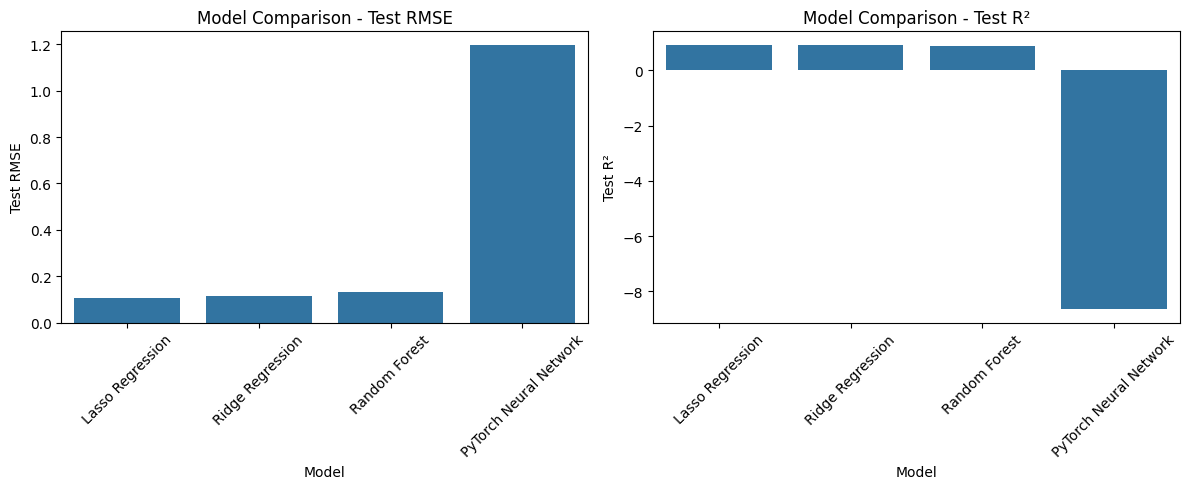

In [16]:
# Visualize model comparison
plt.figure(figsize=(12, 5))

# RMSE comparison
plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='Test RMSE', data=comparison_df)
plt.title('Model Comparison - Test RMSE')
plt.xticks(rotation=45)
plt.tight_layout()

# R² comparison
plt.subplot(1, 2, 2)
sns.barplot(x='Model', y='Test R²', data=comparison_df)
plt.title('Model Comparison - Test R²')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

## 7. Conclusion

In this notebook, we built and evaluated four different regression models for the Ames Housing dataset:

1. Ridge Regression
2. Lasso Regression
3. Random Forest Regression
4. PyTorch Neural Network

We performed proper data preprocessing, including missing value imputation, and evaluated each model using 10-fold cross-validation. The comparison table and visualization help identify the best performing model based on RMSE and R² metrics.

The best performing model can be used for predicting house prices on new data.